In [1]:
#Importing the necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,classification_report,confusion_matrix

In [2]:
#loading the dataset
data = pd .read_csv('manufacturing_sensor_data.csv')
print(data.head())

#checking for null values
print(data.isnull().sum())

             timestamp machine_id      machine_type  temperature  pressure  \
0  2024-01-01 00:00:00       M004    Assembly_Robot        32.78     22.32   
1  2024-01-01 01:00:00       M004  Injection_Molder        65.09     33.72   
2  2024-01-01 02:00:00       M004      Laser_Cutter        52.28     18.22   
3  2024-01-01 03:00:00       M004         CNC_Lathe        38.92     30.24   
4  2024-01-01 04:00:00       M001  Injection_Molder        68.29     31.34   

   vibration      rpm  anomaly  shift operator_id  temp_pressure_ratio  \
0     122.23  2702.10        0  Night        OP05             1.468638   
1      43.40  1788.25        0  Night        OP03             1.930308   
2      60.40  4312.71        0  Night        OP04             2.869374   
3      88.90  3034.84        0  Night        OP03             1.287037   
4      45.63  1604.03        0  Night        OP05             2.179004   

   vibration_rpm_ratio  hour_of_day day_of_week  
0             0.045235            0 

In [3]:
#selecting numerical feature for clustering
numerical_features = ['temperature', 'pressure', 'vibration', 'rpm', 
                     'temp_pressure_ratio', 'vibration_rpm_ratio', 'hour_of_day']

#Preparing feature matrix
X = data[numerical_features].copy()


In [4]:
# Standardize the features (crucial for K-Means and PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
#Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
print(pca_df.head())
print('Explained Variance Ratio = ',pca.explained_variance_ratio_)
# Adding PCA results to main dataframe
data['PC1'] = pca_result[:, 0]
data['PC2'] = pca_result[:, 1]

        PC1       PC2
0  2.456553 -0.444195
1 -2.048052 -1.317151
2 -0.670902  2.216017
3  0.548922 -0.271540
4 -1.875138 -1.435090
Explained Variance Ratio =  [0.38601956 0.26884505]


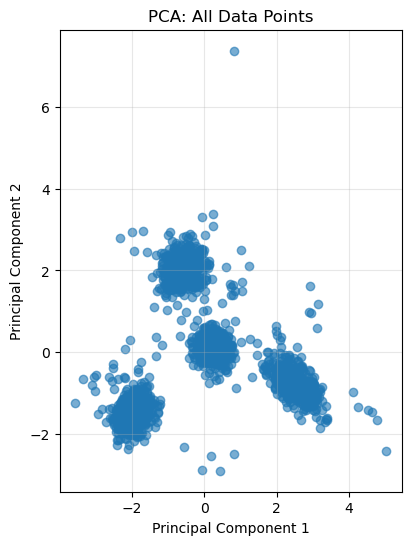

In [6]:
#PCA VISUALIZATION
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: All Data Points')
plt.grid(True, alpha=0.3)
plt.show()

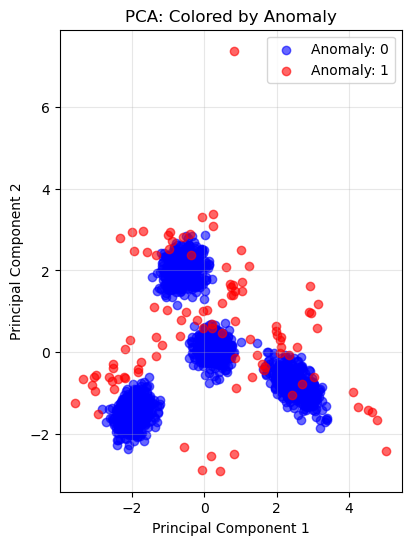

In [7]:
# Color by anomaly
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 2)
colors = ['blue', 'red']
for i, anomaly in enumerate([0, 1]):
    mask = data['anomaly'] == anomaly
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
               c=colors[i], alpha=0.6, label=f'Anomaly: {anomaly}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Colored by Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)

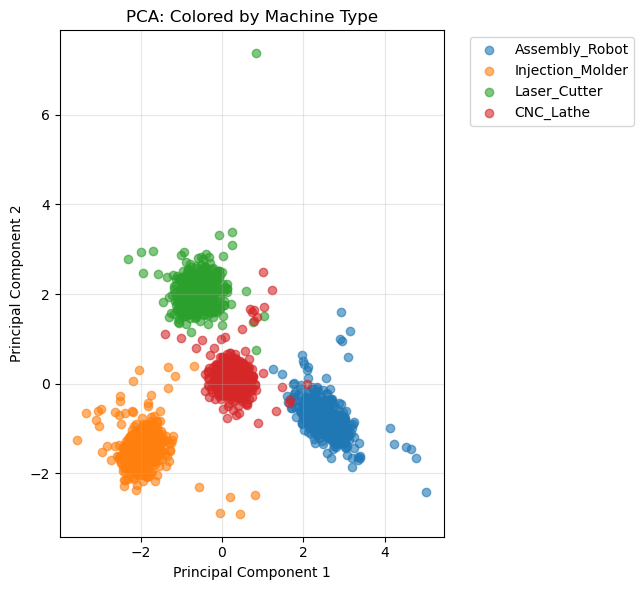

In [8]:
# Color by machine type
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 3)
machine_types = data['machine_type'].unique()
for machine in machine_types:
    mask = data['machine_type'] == machine
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
               alpha=0.6, label=machine)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Colored by Machine Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Using PCA result for clustering
X_pca_optimal = pca_result

In [10]:
#KMeans clustering
# Determining optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca_optimal)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_optimal, cluster_labels))

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


In [11]:
# Finding optimal k (elbow point)
inertia_diff = np.diff(inertia)
inertia_diff_ratio = inertia_diff[:-1] / inertia_diff[1:]
optimal_k_elbow = k_range[np.argmax(inertia_diff_ratio) + 1]


# Finding optimal k (silhouette score)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

print(f"Optimal k (Elbow method): {optimal_k_elbow}")
print(f"Optimal k (Silhouette score): {optimal_k_silhouette}")

Optimal k (Elbow method): 4
Optimal k (Silhouette score): 4


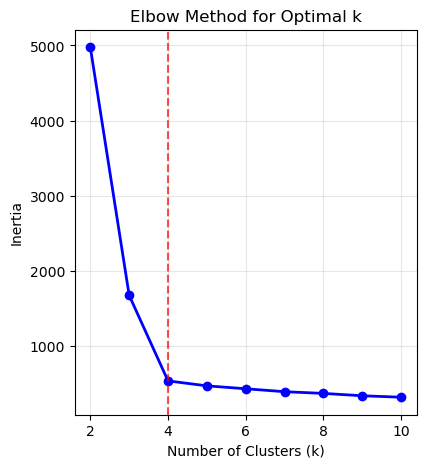

In [12]:
optimal_k = optimal_k_silhouette
# Visualization: Elbow Method and Silhouette Scores
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

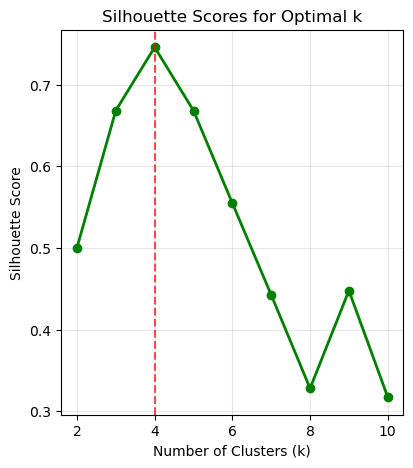

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'go-', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Applying K-Means with optimal k
print(f"\nApplying K-Means with k={optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=15)
cluster_labels = kmeans.fit_predict(X_pca_optimal)
data['cluster'] = cluster_labels
print(f"K-Means clustering completed with {optimal_k} clusters")
print(f"Final inertia: {kmeans.inertia_:.2f}")
print(f"Silhouette score: {silhouette_score(X_pca_optimal, cluster_labels):.3f}")


Applying K-Means with k=4 clusters...
K-Means clustering completed with 4 clusters
Final inertia: 533.08
Silhouette score: 0.746


In [15]:
#Anamoly detection using cluster analysis

#  Distance-based anomaly detection 
def calculate_anomaly_scores(X, kmeans_model):
    """Calculating anomaly scores based on distance to cluster centers"""
    distances = np.min(kmeans_model.transform(X), axis=1)
    # Normalize distances to 0-1 range
    anomaly_scores = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
    return anomaly_scores

# Calculate anomaly scores using only distance-based method
anomaly_scores = calculate_anomaly_scores(X_pca_optimal, kmeans)
data['anomaly_score'] = anomaly_scores

# Set anomaly threshold (top 5% as anomalies)
anomaly_threshold = np.percentile(anomaly_scores, 95)
data['kmeans_anomaly'] = (data['anomaly_score'] > anomaly_threshold).astype(int)

print("Anomaly Detection Results (Distance-based Method ):")
print(f"Distance-based anomalies: {data['kmeans_anomaly'].sum()}")
print(f"Actual labeled anomalies: {data['anomaly'].sum()}")
print(f"Anomaly threshold: {anomaly_threshold:.3f}")

Anomaly Detection Results (Distance-based Method ):
Distance-based anomalies: 100
Actual labeled anomalies: 101
Anomaly threshold: 0.165


In [16]:
#confusion matrix
cm = confusion_matrix(data['anomaly'], data['kmeans_anomaly'])
cm

array([[1877,   22],
       [  23,   78]])

In [17]:
#classification report
class_report = classification_report(data['anomaly'], data['kmeans_anomaly'], 
                                   target_names=['Normal', 'Anomaly'])
print(class_report)

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1899
     Anomaly       0.78      0.77      0.78       101

    accuracy                           0.98      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.98      0.98      0.98      2000



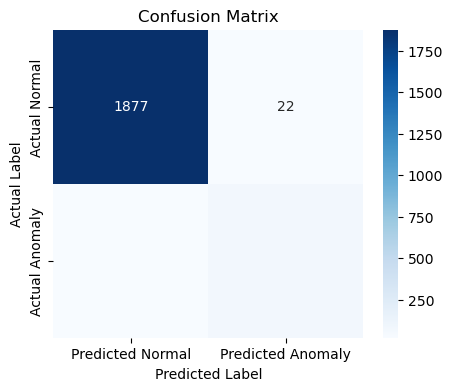

In [18]:
# Confusion Matrix Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted Normal', 'Predicted Anomaly'], 
           yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

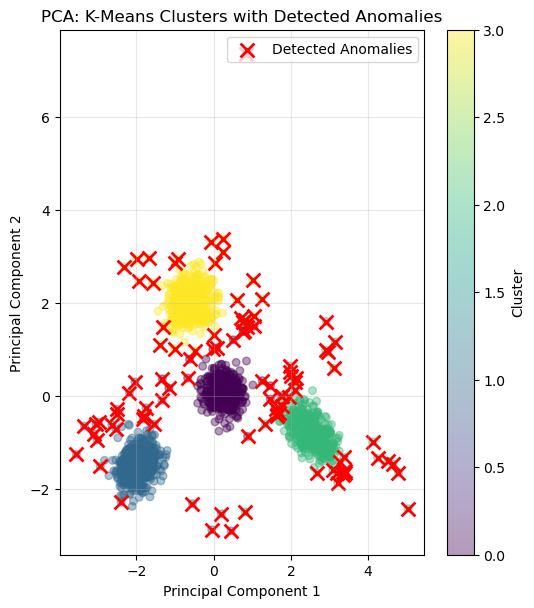

In [19]:
#visualization

# Plot 1: PCA with K-Means Clusters and Detected Anomalies
fig = plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 1)
# Plotting all points colored by cluster
scatter1 = plt.scatter(data['PC1'], data['PC2'], c=data['cluster'], cmap='viridis', alpha=0.4, s=30)
# Highlighting detected anomalies
anomaly_mask = data['kmeans_anomaly'] == 1
plt.scatter(data.loc[anomaly_mask, 'PC1'], data.loc[anomaly_mask, 'PC2'], 
           c='red', marker='x', s=100, linewidth=2, label='Detected Anomalies')
plt.colorbar(scatter1, label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: K-Means Clusters with Detected Anomalies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

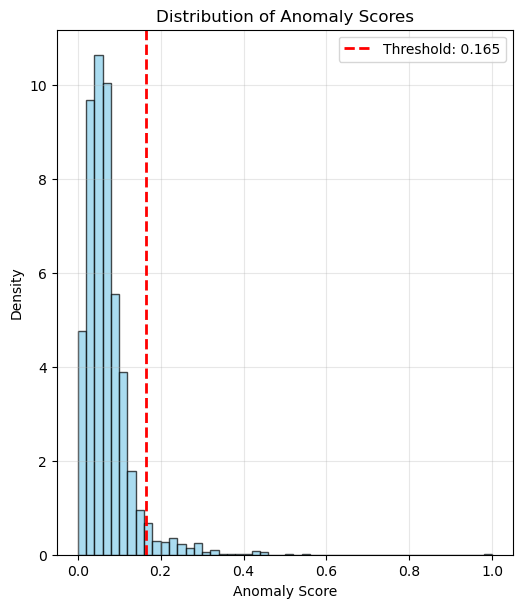

In [20]:
# Plot 2: Anomaly Scores Distribution with Threshold
fig = plt.figure(figsize=(20,15))
plt.subplot(2, 3, 2)
plt.hist(data['anomaly_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold: {anomaly_threshold:.3f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()